Notebook to analyze the results of the BPZ photo-z estimations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load all the data

In [6]:
photoz_results = dict()

names = ['CWW+SB4','CWW+SB4 Trained','N8 Trained','N16 Trained']
filenames = ['cwwsb4','cwwsb4_trained','N8_trained','N16_trained']

for (name,file) in zip(names,filenames):
    
    zp = np.array([])
    zs = np.array([])
    odds = np.array([])
    chi2 = np.array([])
    Tb = np.array([])

    for band in ['i']:
        zb,zspec,pdz,chisq,tb = np.loadtxt('bpz_files/'+file+'_'+band+'_photoz.bpz',skiprows=16,usecols=(1,9,5,11,4),unpack=True)
        
        zp = np.concatenate((zp,zb))
        zs = np.concatenate((zs,zspec))
        odds = np.concatenate((odds,pdz))
        chi2 = np.concatenate((chi2,chisq))
        Tb = np.concatenate((Tb,tb))
        
    photoz_results[name] = {'zp':zp, 'zs':zs, 'odds':odds, 'chi2':chi2, 'type':Tb}

Function to calculate photo-z stats. Adapted from function written by Melissa Graham.

In [7]:
def get_stats(zspec, zphot, zlo, zhi):
    
    # This function will return the statistical measures for a given redshift bin bounded by zlo,zhi.

    # Input definitions 
    #  zspec  =  list of spectroscopic or 'true' redshifts for test galaxies
    #  zphot  =  list of photometric redshift point estimates for test galaxies
    #  zlo    =  low-end redshift of bin
    #  zhi    =  high-end redshift of bin

    # Definitions used in this function.
    #  dzo1pzp              : dz over 1 plus zphot, ( zspec - zphot ) / ( 1 + zphot )
    #  outlier              : test galaxy with |dzo1pzp| > 3*IQRs
    # The definition of an "outlier" comes from the SRD (which calls them 'catastrophic outliers'; ls.st/srd).
    # For outliers, the IQRs used to identify them is calculated from all test galaxies

    # Definitions of the statistical measures.
    #  fout     = fraction of outliers (see note below)
    #  IQR      = interquartile range of dzo1pzp
    #  IQRmean  = the mean zphot of galaxies in the IQR
    #  IQRstdd  = stdandard deviation from the IQR ( = IQR / 1.349 )
    #  IQRbias  = bias of test galaxies in the IQR 

    # Bootstrap resample with replacement to estimate errors for the statistical measures.
    #  Nmc = number of times to repeat measurement
    Nmc  = 1000
    
    # Calculate the IQRs for all test galaxies
    # Will need this to identify outliers using the SRD's definition of an outlier.
    dzo1pzp = (zspec - zphot) / (1.0 + zphot)
    q75, q25   = np.percentile( dzo1pzp, [75 ,25] )
    IQRstdd    = (q75 - q25) / 1.349

    # Identify all test galaxies in the requested bin.
    idx      = np.where( ( zphot > zlo ) & ( zphot <= zhi ) )
    in_zspec = zspec[idx]
    in_zphot = zphot[idx]
    
    # Define bin_dzo1pzp for use in all stats
    dzo1pzp    = (in_zspec - in_zphot) / (1.0 + in_zphot)

    # Fraction of outliers as defined by the SRD
    idx  = np.where( np.fabs( dzo1pzp ) > (3.0*IQRstdd) )[0]
    fout = float(len(idx)) / float(len(dzo1pzp))
    
    # Interquartile Range
    q75, q25 = np.percentile( dzo1pzp, [75 ,25] )
    IQRstdd  = ( q75 - q25 ) / 1.349
    idx      = np.where( ( dzo1pzp > q25 ) & ( dzo1pzp < q75 ) )
    IQRbias  = np.mean(dzo1pzp[idx])
    IQRmean  = np.mean(in_zphot[idx])
    
    ### Now bootstrap and calculate errors for scatter and bias and mean
    vals_IQRs = np.zeros(Nmc, dtype='float')
    vals_IQRb = np.zeros(Nmc, dtype='float')
    vals_IQRm = np.zeros(Nmc, dtype='float')
    for i in range(Nmc):
        idx = np.random.choice( len(dzo1pzp), size=len(dzo1pzp), replace=True, p=None )
        q75, q25     = np.percentile( dzo1pzp[idx], [75 ,25] )
        vals_IQRs[i] = ( q75 - q25 ) / 1.349
        temp1        = dzo1pzp[idx]
        temp2        = in_zphot[idx]
        idx          = np.where( ( temp1 > q25 ) & ( temp1 < q75 ) )[0]
        vals_IQRb[i] = np.mean(temp1[idx])
        vals_IQRm[i] = np.mean(temp2[idx])

    eIQRstdd = np.std( vals_IQRs )
    eIQRbias = np.std( vals_IQRb )
    eIQRmean = np.std( vals_IQRb )

    return fout, IQRmean, eIQRmean, IQRstdd, eIQRstdd, IQRbias, eIQRbias


Plot the photo-z results with global stats

CWW+SB4 Fraction cut: 0.278
CWW+SB4 Trained Fraction cut: 0.298
N8 Trained Fraction cut: 0.243
N16 Trained Fraction cut: 0.249


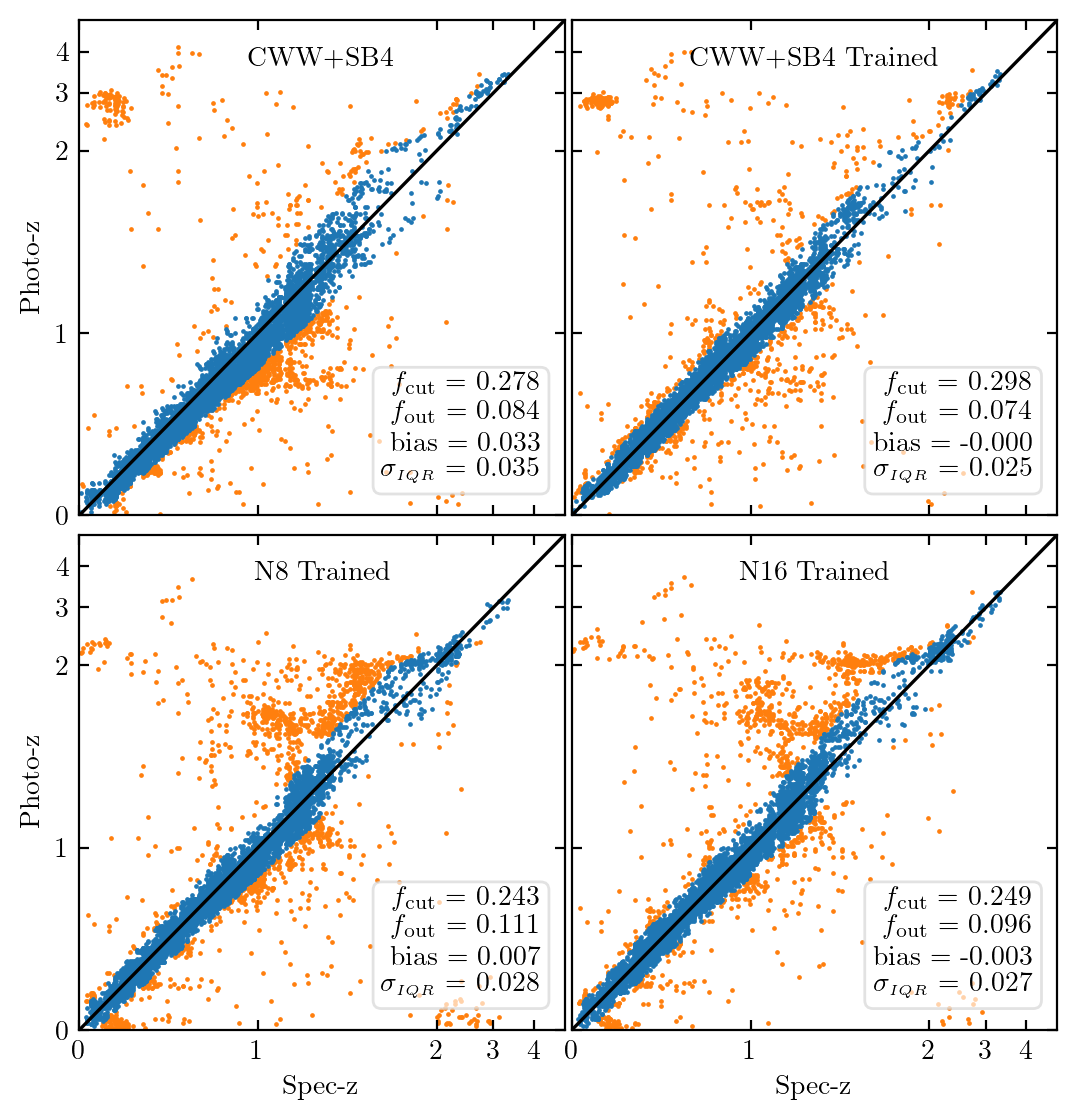

In [8]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(twocol*0.75,twocol*0.78))

for name,ax in zip(photoz_results,axes.flatten()):
    
    zs = photoz_results[name]['zs']
    zp = photoz_results[name]['zp']
    odds = photoz_results[name]['odds']
    chi2 = photoz_results[name]['chi2']
    
    # cut based on BPZ stats
    idx = np.where( (odds > 0.95) & (chi2 < 1) )
    fcut = 1-len(idx[0])/len(zp)
    print(name,"Fraction cut: {0:.3f}".format(fcut))
    zs = zs[idx]
    zp = zp[idx]
    
    # calculate stats
    stats = get_stats(zs,zp,0,max(zp))
    
    # plot outliers, then inliers
    IQRstdd = stats[3]
    dzo1pzp = (zs - zp)/(1.0 + zp)
    idx = np.where( np.fabs( dzo1pzp ) > (3.0*IQRstdd) )
    ax.scatter(zs[idx], zp[idx], c='C1',s=0.5, alpha=1)
    idx = np.where( np.fabs( dzo1pzp ) <= (3.0*IQRstdd) )
    ax.scatter(zs[idx], zp[idx], c='C0', s=0.5, alpha=1)
    
    # plot y=x to guide the eye
    ax.plot([0,7], [0,7], c='k')
    
    # print global stats on each plot
    fout = stats[0]
    IQRstdd = stats[3]
    errIQRstdd = stats[4]
    IQRbias = stats[5]
    errIQRbias = stats[6]
    text = '$f_{\mathrm{cut}}$ = '+'{0:.3f}\n'.format(fcut) +\
            '$f_{\mathrm{out}}$ = '+'{0:.3f}\n'.format(fout) +\
            'bias = '+'{0:.3f}\n'.format(IQRbias) +\
            '$\sigma_{\scriptscriptstyle IQR}$ = '+'{0:.3f}'.format(IQRstdd)
    ax.text(0.95,0.06, text, transform=ax.transAxes,ha='right',va='bottom',
        bbox=dict(facecolor='white', alpha=0.65, edgecolor='lightgrey', boxstyle='round'))
    
    ax.text(0.5,0.92, name, transform=ax.transAxes,ha='center',va='center')
    

for i in [0,1]:
    axes[1,i].set_xlabel('Spec-z')
    axes[1,i].set_xlim(0,5)
    axes[1,i].set_xscale('symlog')
    axes[1,i].set_xticks([0,1,2,3,4])
    axes[1,i].set_xticklabels([0,1,2,3,4])

    axes[i,0].set_ylabel("Photo-z")
    axes[i,0].set_ylim(0,5)
    axes[i,0].set_yscale('symlog')
    axes[i,0].set_yticks([0,1,2,3,4])
    axes[i,0].set_yticklabels([0,1,2,3,4])

fig.tight_layout(pad=0.5, h_pad=0.15, w_pad=0)
#fig.savefig('plots/photoz_results.png')
plt.show()

CWW+SB4 Fraction cut: 0.278
CWW+SB4 Trained Fraction cut: 0.298
N8 Trained Fraction cut: 0.247
N16 Trained Fraction cut: 0.249


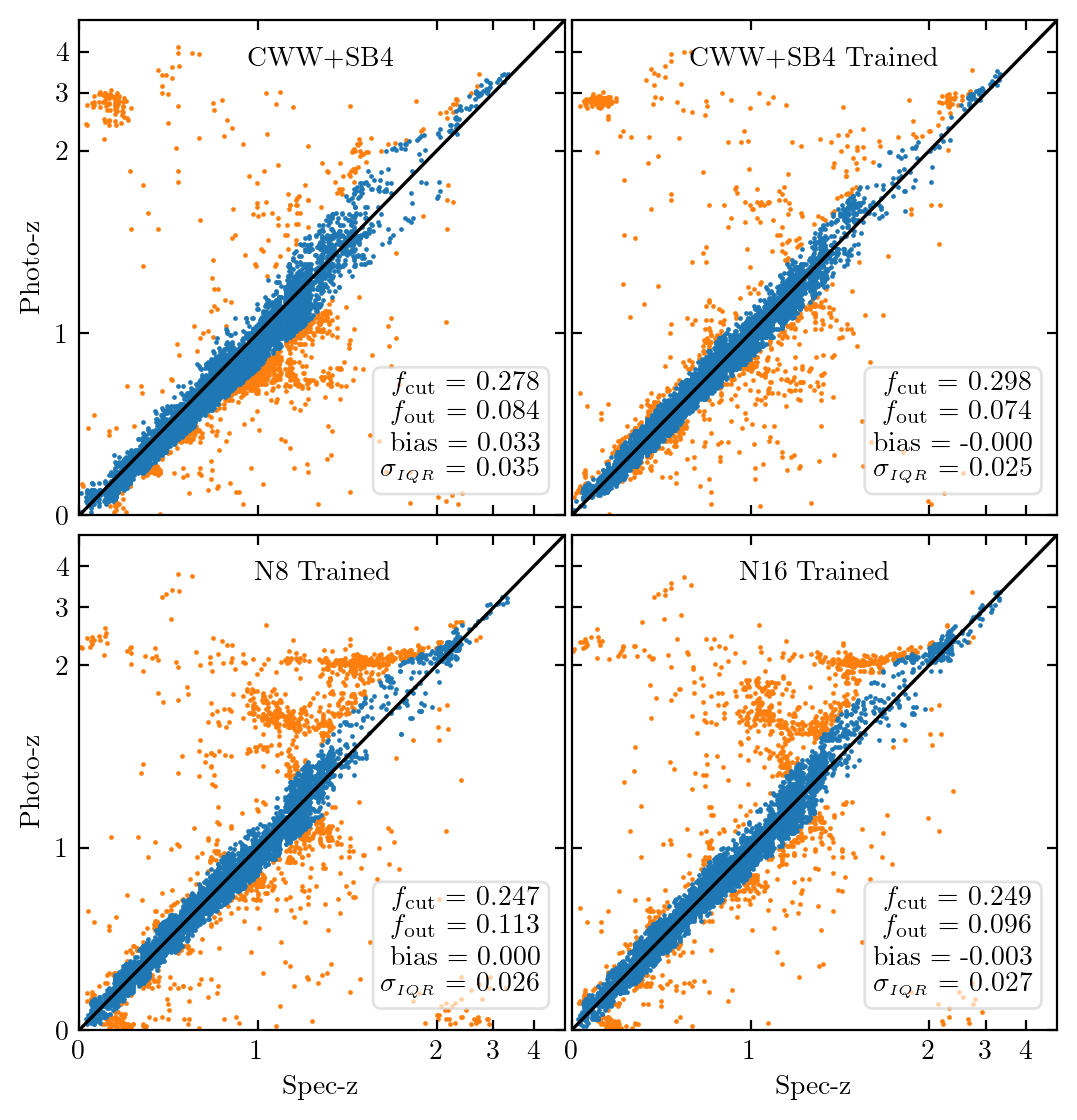

In [6]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(twocol*0.75,twocol*0.78))

for name,ax in zip(photoz_results,axes.flatten()):
    
    zs = photoz_results[name]['zs']
    zp = photoz_results[name]['zp']
    odds = photoz_results[name]['odds']
    chi2 = photoz_results[name]['chi2']
    
    # cut based on BPZ stats
    idx = np.where( (odds > 0.95) & (chi2 < 1) )
    fcut = 1-len(idx[0])/len(zp)
    print(name,"Fraction cut: {0:.3f}".format(fcut))
    zs = zs[idx]
    zp = zp[idx]
    
    # calculate stats
    stats = get_stats(zs,zp,0,max(zp))
    
    # plot outliers, then inliers
    IQRstdd = stats[3]
    dzo1pzp = (zs - zp)/(1.0 + zp)
    idx = np.where( np.fabs( dzo1pzp ) > (3.0*IQRstdd) )
    ax.scatter(zs[idx], zp[idx], c='C1',s=0.5, alpha=1)
    idx = np.where( np.fabs( dzo1pzp ) <= (3.0*IQRstdd) )
    ax.scatter(zs[idx], zp[idx], c='C0', s=0.5, alpha=1)
    
    # plot y=x to guide the eye
    ax.plot([0,7], [0,7], c='k')
    
    # print global stats on each plot
    fout = stats[0]
    IQRstdd = stats[3]
    errIQRstdd = stats[4]
    IQRbias = stats[5]
    errIQRbias = stats[6]
    text = '$f_{\mathrm{cut}}$ = '+'{0:.3f}\n'.format(fcut) +\
            '$f_{\mathrm{out}}$ = '+'{0:.3f}\n'.format(fout) +\
            'bias = '+'{0:.3f}\n'.format(IQRbias) +\
            '$\sigma_{\scriptscriptstyle IQR}$ = '+'{0:.3f}'.format(IQRstdd)
    ax.text(0.95,0.06, text, transform=ax.transAxes,ha='right',va='bottom',
        bbox=dict(facecolor='white', alpha=0.65, edgecolor='lightgrey', boxstyle='round'))
    
    ax.text(0.5,0.92, name, transform=ax.transAxes,ha='center',va='center')
    

for i in [0,1]:
    axes[1,i].set_xlabel('Spec-z')
    axes[1,i].set_xlim(0,5)
    axes[1,i].set_xscale('symlog')
    axes[1,i].set_xticks([0,1,2,3,4])
    axes[1,i].set_xticklabels([0,1,2,3,4])

    axes[i,0].set_ylabel("Photo-z")
    axes[i,0].set_ylim(0,5)
    axes[i,0].set_yscale('symlog')
    axes[i,0].set_yticks([0,1,2,3,4])
    axes[i,0].set_yticklabels([0,1,2,3,4])

fig.tight_layout(pad=0.5, h_pad=0.15, w_pad=0)
#fig.savefig('plots/photoz_results.png')
plt.show()

Now plot the stats in redshift bins

In [7]:
binned_data = dict()

for name in photoz_results:
    
    binned_data[name] = []
    data = photoz_results[name]
    zs, zp, odds, chi2 = data['zs'], data['zp'], data['odds'], data['chi2']
    
    idx = np.where( (odds > 0.95) & (chi2 < 1) )
    fcut = 1-len(idx[0])/len(zp)
    zs = zs[idx]
    zp = zp[idx]
    
    step = 0.2
    zmax = 1.8
    nbins = int(zmax/step + 1.5)
    zbins = np.linspace(0,zmax,nbins)
    for i in range(len(zbins)-1):
        
        stats = get_stats(zs,zp,zbins[i],zbins[i+1])

        IQRmean = stats[1]
        errIQRmean = stats[2]
        fout = stats[0]
        IQRbias = stats[5]
        errIQRbias = stats[6]        
        IQRstdd = stats[3]
        errIQRstdd = stats[4]
        
        binned_data[name].append([IQRmean,errIQRmean,fout,IQRbias,errIQRbias,IQRstdd,errIQRstdd])
        
    binned_data[name] = np.array(binned_data[name])
        

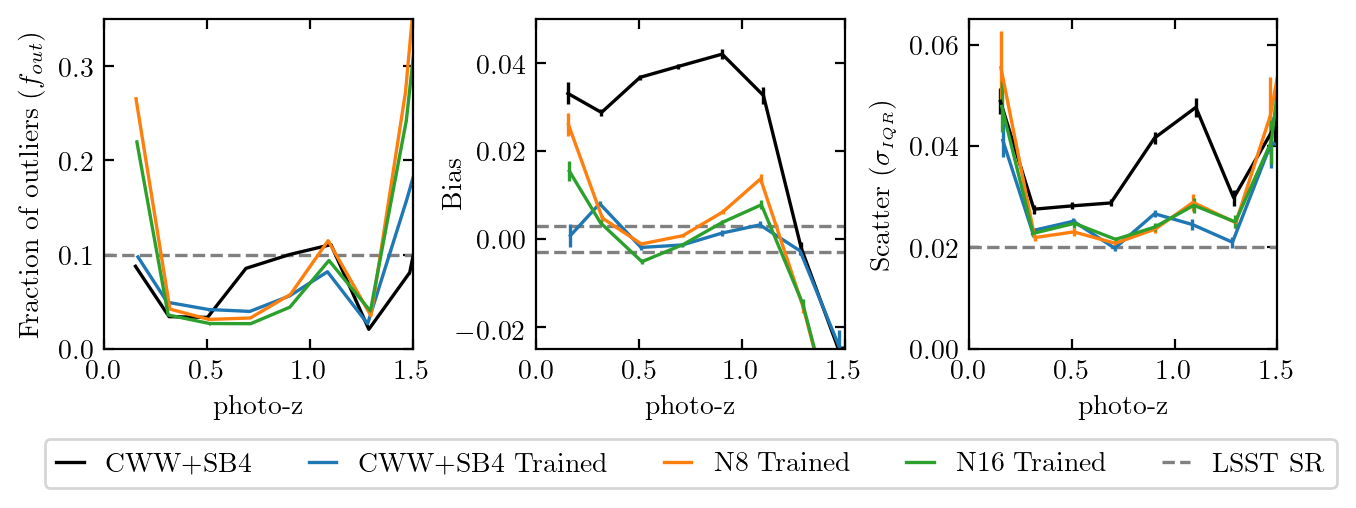

In [8]:
fig = plt.figure(figsize=(twocol,0.37*twocol))
gs = gridspec.GridSpec(2,3,height_ratios=[10,1])

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
legend = plt.subplot(gs[1,:])

colors = ['k','C0','C1','C2']

for (name,color) in zip(names,colors):
  
    data = binned_data[name]
    
    ax1.errorbar(data[:,0],data[:,2],xerr=data[:,1],c=color)
    ax2.errorbar(data[:,0],data[:,3],xerr=data[:,1],yerr=data[:,4],c=color)
    ax3.errorbar(data[:,0],data[:,5],xerr=data[:,1],yerr=data[:,6],c=color)
    legend.plot([1],[1],c=color,label=name)

ax1.set_xlabel("photo-z")
ax1.set_xlim(0,1.5)
ax1.set_ylabel("Fraction of outliers ($f_{out}$)")
ax1.set_ylim(0,0.35)
ax1.plot([0,5],[0.1,0.1],c='gray',ls='--')

ax2.set_xlabel("photo-z")
ax2.set_xlim(0,1.5)
ax2.set_ylabel("Bias",labelpad=-4)
ax2.set_ylim(-0.025,0.05)
ax2.plot([0,5],[0.003,0.003],c='gray',ls='--')
ax2.plot([0,5],[-0.003,-0.003],c='gray',ls='--')

ax3.set_xlabel("photo-z")
ax3.set_xlim(0,1.5)
ax3.set_ylabel("Scatter ($\sigma_{\scriptscriptstyle IQR}$)")
ax3.set_ylim(0.00,0.065)
ax3.plot([0,5],[0.02,0.02],c='gray',ls='--')

legend.plot([1],[1],c='gray',ls='--',label="LSST SR")
legend.legend(loc='upper center', bbox_to_anchor=(0.5, 0.8),fancybox=True, ncol=5,handlelength=1)
legend.axis('off')

fig.tight_layout(pad=1, h_pad=0, w_pad=0.3)
fig.savefig('plots/photoz_binned_metrics.pdf')